In [1]:
from numpy import *
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal as signal
import numpy as np

## Drawing function. 

In [2]:
def plot(x,y):
    x_set = np.arange(0, len(x), 1)
    plt.subplot(211)
    labels1 = []
    plt.xlabel("time stamp")
    plt.ylabel("speed")
    plt.plot(x_set, x, 'b', linewidth=2)
    labels1.append(r'Data x ')
    plt.legend(labels1, ncol=4, loc='upper right',
               bbox_to_anchor=[1, 1],
               columnspacing=1.0, labelspacing=0.2,
               handletextpad=0.2, handlelength=1.5,
               fancybox=True, shadow=True)
    plt.subplot(212)
    labels2 = []
    plt.xlabel("speed")
    plt.ylabel("time stamp")
    plt.plot(x_set, y, 'g', linewidth=2)
    labels2.append(r'Data y ')
    plt.legend(labels2, ncol=4, loc='upper right',
               bbox_to_anchor=[1, 1],
               columnspacing=1.0, labelspacing=0.2,
               handletextpad=0.2, handlelength=1.5,
               fancybox=True, shadow=True)
    plt.show()

## Data loading function. 
Find the mean value of each road in 'days (days<=7)' days, generally 'days' is 7, if the data is less than 7 days, then the largest integer value less than 7 is taken. 

In [3]:
def loadData(filename,sample_frequency):
    data = filename#np.load(filename)#nodes,timestamp
    days=min(7,math.floor(data.shape[1]/sample_frequency))
    Y = np.array(data[ :, 0:days*sample_frequency])
    Y_re=Y.reshape([-1,days,sample_frequency])#nodes,days,samples
    Y_sum=Y_re.sum(axis=1)
    Y_nz=np.count_nonzero(Y_re, axis=1)
    Y_nz[Y_nz == 0] = 1
    Y_mean=Y_sum/Y_nz
    return Y_mean #node, fre

## Sampling frequency unity function. 
For two datasets with different sampling frequencies, we need to make them have the same frequency by upsampling or downsampling.

In [4]:
def fre_uni(datax,datay):
    frex=datax.shape[1]
    n_tar = signal.resample(datay.T, frex)
    return datax,n_tar.T

## Timestamp alignment function. 
A certain time stamp (e.g., midnight, noon) was determined as the starting point for both data.

In [5]:
def timestamp_alignment(datax,datay):
    #print(datax.shape,'dataxshape') node,samples
    x_nz = np.count_nonzero(datax, axis=0)
    y_nz = np.count_nonzero(datay, axis=0)
    x_nz[x_nz == 0] = 1
    y_nz[y_nz == 0] = 1
    x_sum = datax.sum(axis=0)
    y_sum = datay.sum(axis=0)
    mean_sequence_x=x_sum/x_nz
    mean_sequence_y = y_sum / y_nz
    plot(mean_sequence_x,mean_sequence_y)
    mark_x=np.argmin(mean_sequence_x)
    mark_y = np.argmin(mean_sequence_y)
    x_a,x_b=datax.T[0:mark_x],datax.T[mark_x:]
    y_a, y_b = datay.T[0:mark_y], datay.T[mark_y:]
    n_datax=np.append(x_b,x_a,axis=0).T
    n_datay = np.append(y_b, y_a,axis=0).T
    return n_datax,n_datay

## Data set similarity calculation function. 
KL distance is regarded as an index to measure the similarity of two data sets.

In [6]:
def Simcaculate(x,y):
    Sim = []
    for i in range(len(x)):
        if 0 in x[i]:continue
        s = []
        for j in range(len(y)):
            if 0 in y[j]:
                KL = 0
            else:
                KL = np.exp(-scipy.stats.entropy(x[i], y[j]))
            s.append(KL)
        Sim.append(max(s))
    Sim = np.mean(Sim)
    return Sim

## Running the code.
### We choose **PEMS04**, **PEMS08**, **CD_S**, **SZ_S** as the data sets to be compared. 
The PEMS series data sets contain flow, occupancy and speed, which are denoted by *_f*, *_o* and *_s* respectively. CD_S and SZ_S are speed data sets.

In [7]:
data_pems04_f=np.load('PEMS04_f.npy')[:,60:]#nodes, samples
data_pems08_f=np.load('PEMS08_f.npy')
data_pems04_o=np.load('PEMS04_o.npy')[:,60:]
data_pems08_o=np.load('PEMS08_o.npy')
data_pems04_s=np.load('PEMS04_s.npy')[:,60:]
data_pems08_s=np.load('PEMS08_s.npy')
data_CD=np.load('CD_S.npy')[:,100:]
data_SZ=np.load('SZ_S.npy')
print('shape of data_pems04_f:', data_pems04_f.shape)
print('shape of data_pems08_f:', data_pems08_f.shape)
print('shape of data_pems04_o:', data_pems04_o.shape)
print('shape of data_pems08_o:', data_pems08_o.shape)
print('shape of data_pems04_s:', data_pems04_s.shape)
print('shape of data_pems08_s:', data_pems08_s.shape)
print('shape of data_CD:', data_CD.shape)
print('shape of data_SZ:', data_SZ.shape)

shape of data_pems04_f: (307, 16932)
shape of data_pems08_f: (170, 17856)
shape of data_pems04_o: (307, 16932)
shape of data_pems08_o: (170, 17856)
shape of data_pems04_s: (307, 16932)
shape of data_pems08_s: (170, 17856)
shape of data_CD: (826, 45404)
shape of data_SZ: (1174, 52293)


### Select the data set to be compared （ data_pems04_f，data_pems08_f） and input its sampling frequency. 
Here we input the value of twice the sampling frequency to show a more obvious visualization.

In [8]:
x=loadData(data_pems04_f,288*2)#datases, sample frequency
y=loadData(data_pems08_f,288*2)

### Unify the sampling frequency.

In [9]:
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)

(307, 576)
(170, 576)


### Align the timestamps of the two datasets.

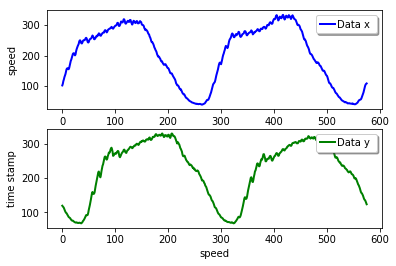

In [10]:
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)

### Let's take a look at the result of the alignment.
( borrow the plot function from timestamp_alignment().)

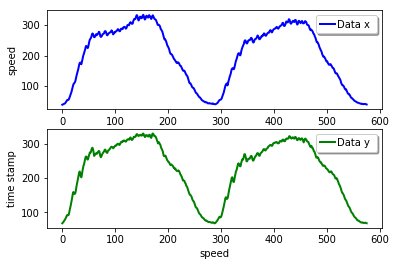

In [11]:
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)

### Finally, we compute the distributional similarity of the two sequences.

In [12]:
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems04_f and data_pems08_f :',Sim)

The similarity between data_pems04_f and data_pems08_f : 0.9882922255891483


## Distribution similarity of CS_S and SZ_S.

(826, 288)
(1174, 288)


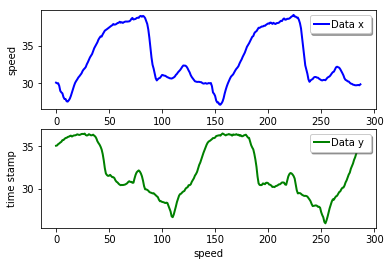

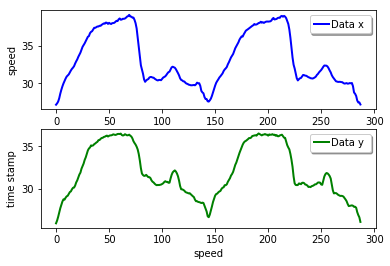

The similarity between CD_S and SZ_S : 0.9969925086245327


In [13]:
x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_SZ,144*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between CD_S and SZ_S :',Sim)

## Distribution similarity of data_pems04_f and data_pems04_s.

(307, 576)
(307, 576)


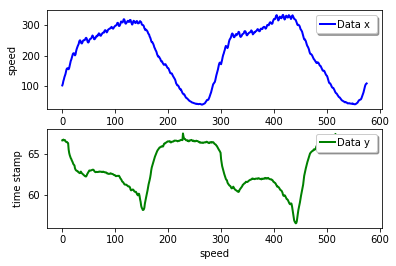

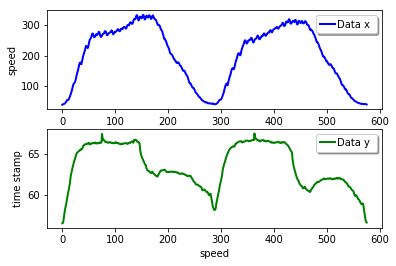

The similarity between data_pems04_f and data_pems04_s : 0.9249753383619705


In [14]:
x=loadData(data_pems04_f,288*2)#datases, sample frequency
y=loadData(data_pems04_s,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems04_f and data_pems04_s :',Sim)

## Distribution similarity of data_pems04_f and data_pems04_o.

(307, 576)
(307, 576)


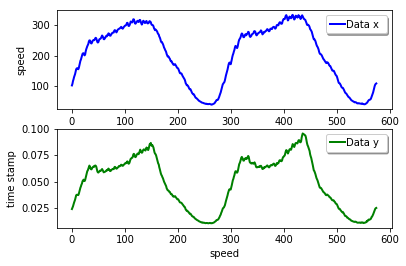

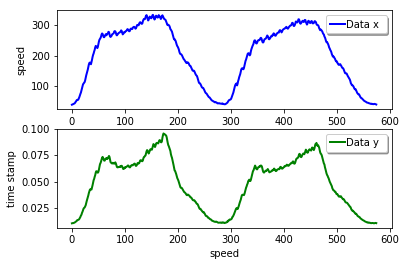

The similarity between data_pems04_f and data_pems04_o : 0.9937667426951875


In [15]:
x=loadData(data_pems04_f,288*2)#datases, sample frequency
y=loadData(data_pems04_o,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems04_f and data_pems04_o :',Sim)

## Distribution similarity of data_pems04_s and data_pems04_o.

(307, 576)
(307, 576)


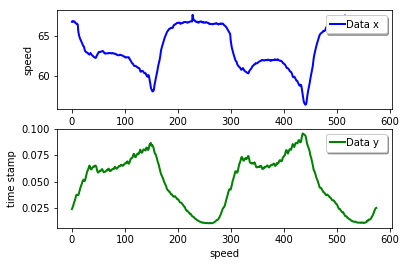

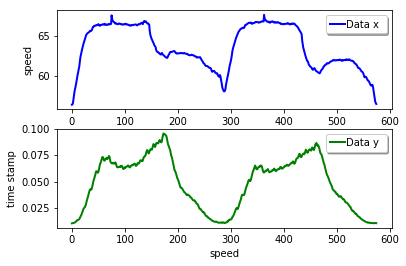

The similarity between data_pems04_s and data_pems04_o : 0.9730778513872816


In [16]:
x=loadData(data_pems04_s,288*2)#datases, sample frequency
y=loadData(data_pems04_o,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems04_s and data_pems04_o :',Sim)

## Distribution similarity of data_pems08_f and pems08_s.

(170, 576)
(170, 576)


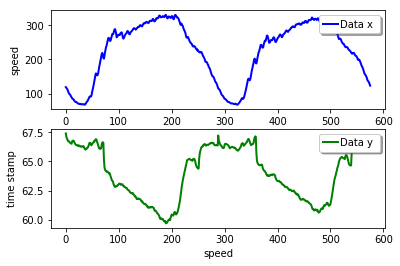

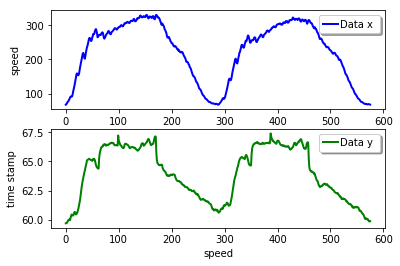

The similarity between data_pems08_f and data_pems08_s : 0.9624952637746818


In [17]:
x=loadData(data_pems08_f,288*2)#datases, sample frequency
y=loadData(data_pems08_s,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems08_f and data_pems08_s :',Sim)

## Distribution similarity of data_pems08_f and pems08_o.

(170, 576)
(170, 576)


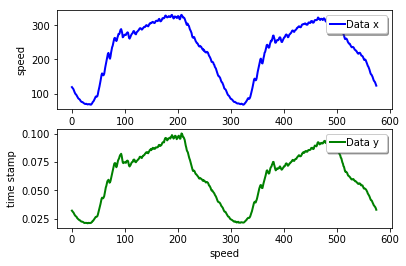

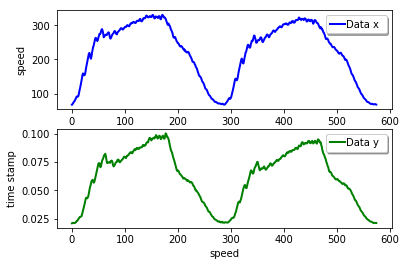

The similarity between data_pems08_f and data_pems08_s : 0.993582728717272


In [18]:
x=loadData(data_pems08_f,288*2)#datases, sample frequency
y=loadData(data_pems08_o,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems08_f and data_pems08_s :',Sim)

## Distribution similarity of data_pems08_s and pems08_o.

(170, 576)
(170, 576)


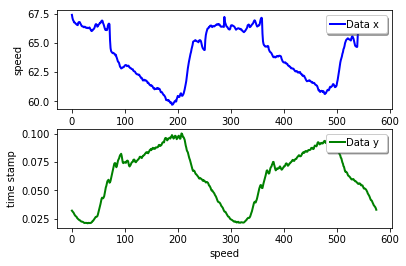

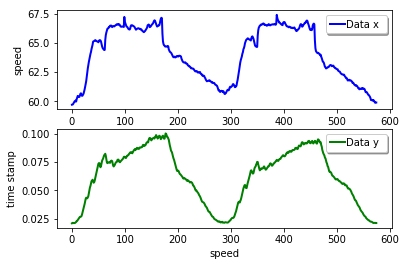

The similarity between data_pems08_s and data_pems08_s : 0.9897476173034915


In [19]:
x=loadData(data_pems08_s,288*2)#datases, sample frequency
y=loadData(data_pems08_o,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_pems08_s and data_pems08_s :',Sim)

## Distribution similarity of CD_S and data_pems04_f.

(826, 288)
(307, 288)


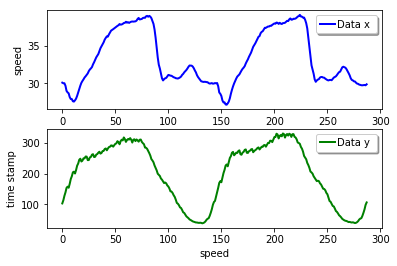

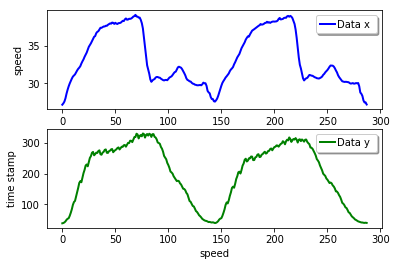

The similarity between CD_S and pems04_f : 0.9763444166148788


In [20]:
x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_pems04_f,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between CD_S and pems04_f :',Sim)

## Distribution similarity of CD_S and data_pems04_s.

(826, 288)
(307, 288)


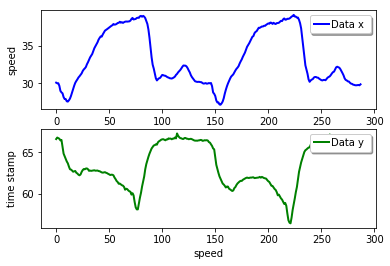

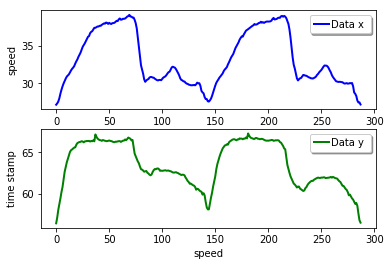

The similarity between CD_S and pems04_s : 0.99476713390713


In [21]:
x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_pems04_s,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between CD_S and pems04_s :',Sim)

## We compare traffic dataset with energy dataset.

(1178, 48)
(307, 48)


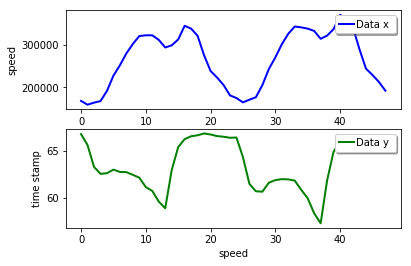

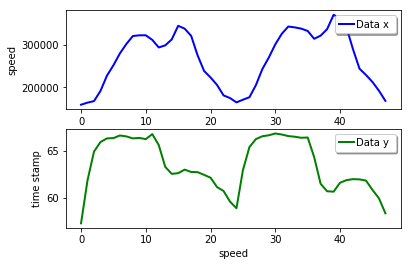

The similarity between data_energy and pems04_s : 0.9544465585710293


In [22]:
data_energy=np.load('energy.npy')
x=loadData(data_energy,24*2)#datases, sample frequency
y=loadData(data_pems04_s,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_energy and pems04_s :',Sim)

## We compare traffic dataset with Gaussian distributed random data.

(100, 100)
(307, 100)


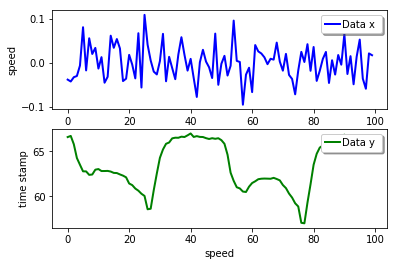

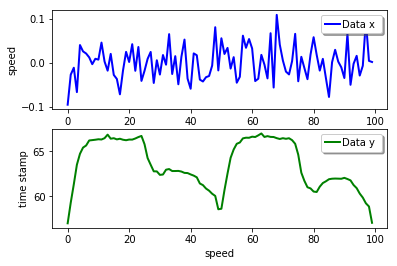

The similarity between data_random and pems04_s : 0.0


In [23]:
random_data=np.random.normal(size=(100, 10000))
x=loadData(random_data,100)#datases, sample frequency
y=loadData(data_pems04_s,288*2)
x_re, y_re = fre_uni(x, y)
print(x_re.shape)
print(y_re.shape)
x_aligned,y_aligned=timestamp_alignment(x_re,y_re)
x_aligned,y_aligned=timestamp_alignment(x_aligned,y_aligned)#just show the effect of alignment.
Sim=Simcaculate(x_aligned,y_aligned)
print('The similarity between data_random and pems04_s :',Sim)